# Imports

In [ ]:
!apt install imagemagick
!pip install pystoned

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.12).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [ ]:
!pip install --upgrade cvxpy

     |████████████████████████████████| 2.8 MB 5.4 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [ ]:
!pip install mosek

In [ ]:
from sklearn import linear_model
from scipy.optimize import curve_fit
from scipy.optimize import nnls
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
# import pwlf
import matplotlib.animation as animation
from matplotlib import rc

# import packages
import pystoned
from pystoned import CNLS
from pystoned.plot import plot2d, plot3d
from pystoned.constant import CET_MULT, FUN_PROD, FUN_COST, OPT_LOCAL, RTS_VRS, RTS_CRS
from pystoned.constant import CET_ADDI, FUN_PROD, RTS_VRS
from pystoned.dataset import load_Finnish_electricity_firm


rc('animation', html='jshtml')

In [ ]:
print(cp.__version__)

1.2.1


In [ ]:
print(cp.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


In [ ]:
import math
print(math.pi)
print(math.exp(1))

3.141592653589793
2.718281828459045


# Tools

## pyStoNED

In [ ]:
myemail = 'jzae2019@mymail.pomona.edu'

### 1-Dimensional CNLS

Estimating the additive model remotely with mosek solver.


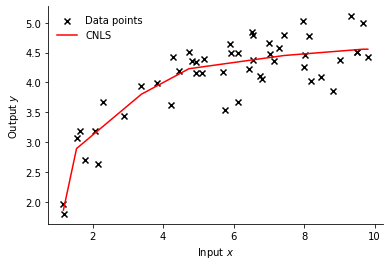

In [ ]:
from pystoned.constant import CET_ADDI, FUN_PROD, RTS_VRS

# set seed
np.random.seed(0)

# generate DMUs: DGP
x = np.sort(np.random.uniform(low=1, high=10, size=50))
u = np.abs(np.random.normal(loc=0, scale=0.7, size=50))
y_true = 3 + np.log(x)
y = y_true - u

# define the CNLS model
model = CNLS.CNLS(y, x, z=None, cet = CET_ADDI, fun = FUN_PROD, rts = RTS_VRS)
# solve the model with remote solver
model.optimize(myemail)

# display the residuals
# model.display_residual()
alphas = model.get_adjusted_alpha()
betas = model.get_beta()

# plot CNLS frontier
plot2d(model, x_select=0, label_name="CNLS", fig_name='CNLS_frontier')

### 2-Dimensional Multiplicative CNLS

Estimating the additive model remotely with mosek solver.


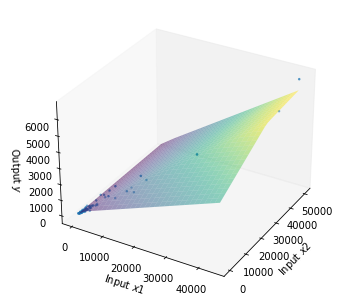

In [ ]:
# import Finnish electricity distribution firms data
data = load_Finnish_electricity_firm(x_select=['OPEX', 'CAPEX'],
                                      y_select=['Energy'])

# define and solve the CNLS model
model = CNLS.CNLS(y=data.y, x=data.x, z=None,
                    cet = CET_ADDI, fun = FUN_PROD, rts = RTS_VRS)


model.optimize(myemail)

# Plot the estimated function
plot3d(model,x_select_1=0, x_select_2=1, fig_name="CNLS_3d")

# Library

## Utilities

In [ ]:
###################################################
def normalize_vector(vector):
    if np.sum(vector) == 0:
      results = np.zeros(vector.shape)
    else:
      results = vector / (np.sum(vector))

    return results



################### Utility Functions ##########################

def get_linear_util(demands, valuations):
    util = np.sum(demands * valuations, axis = 1) 
    return util


def get_leontief_util(demands, valuations):
    util =  np.min(demands/valuations.clip(min = 0.001), axis = 1) 
    return util + 10

def get_cd_util(demands, valuations):
    util = np.sum(np.log(demands.clip(min = 0.001))*valuations, axis = 1) 
    return util + 100


#################### Utility Gradient Functions #####################
def get_linear_util_gradient(allocations, valuations):
    return valuations

def get_leontief_util_gradient(allocations, valuations):
    grad_matrix = []
    argmins = np.argmin(allocations/valuations.clip(min = 0.001), axis = 0)
    marginal_utils = np.zeros(allocations.shape)
    
    for buyer in range(allocations.shape[0]):
      marginal_utils[buyer, argmins[buyer] ] = 1 / valuations[buyer, argmins[buyer]].clip(min = 0.001)
    
    return marginal_utils

def get_cd_util_gradient(allocations, valuations):
    # return ( np.prod(np.power(allocations, valuations), axis = 1)*( valuations / allocations.clip(min = 0.001) ).T).T
    return ( valuations / allocations.clip(min = 0.001) )

################### Min-Max Objective Functions ##########################

def get_linear_obj(prices, demands, budgets, valuations):
  utils = np.sum(valuations * demands, axis = 1)
  return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001)) 


def get_leontief_obj(prices, demands, budgets, valuations):
    utils = np.min(demands/valuations, axis = 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001)) 


def get_cd_obj(prices, demands, budgets, valuations):
    utils = np.prod(np.power(demands, valuations), axis= 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001)) 


################### Heuristic objective function ##########################
def get_global(X, get_obj, prices, budgets, valuations, value_coefs, value_intercepts):
  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  X = X.reshape((num_buyers, num_goods + 1))
  
  demands = X[:, :-1]
  savings = X[:, -1]
  demands = demands.clip(min = 0.0001)
  savings = savings.clip(min = 0.0001)

  return -(get_obj(prices, demands, budgets-savings, valuations) + discount*(np.min(value_coefs @ savings + value_intercepts)) )

# Stochastic Fisher Market w/ Linear Fitted Value Iteration

## Functions

###Deterministic Min_Max Step Linear

In [ ]:
np.set_printoptions(precision=8)

def min_max_value_deterministic_linear(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices,
                         num_iters_prices, utility_type):
  prices = np.zeros(valuations.shape[1]).clip(min=0.1)
  # print(f"valuations: {valuations}")
  if utility_type == "linear":
      get_util = get_linear_util
      get_marginal_util = get_linear_util_gradient
      get_obj = get_linear_obj

  elif utility_type == "leontief":
      get_util = get_leontief_util
      get_marginal_util = get_leontief_util_gradient
      get_obj = get_leontief_obj

  elif utility_type == "cd":
      get_util = get_cd_util
      get_marginal_util = get_cd_util_gradient
      get_obj = get_cd_obj

  prices_step_sizes = []
  excess_demands_hist = []

  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]

  old_prices = np.zeros(valuations.shape[1]).clip(min=0.1)
  
  for iter_outer in range(1, num_iters_prices):
    if not(iter_outer % 50):
      print(f"\n****Min-Max Price Iteration {iter_outer}****")
    # demands = np.zeros((num_buyers, num_goods)).clip(min = 1.00)
    

    X = cp.Variable(valuations.shape)
    if utility_type == "linear":
      util = cp.sum(cp.multiply(valuations, X), axis=1)
    elif utility_type == "leontief":
      util = cp.min(cp.multiply(1/valuations, X), axis=1)
    elif utility_type == "cd":
      util = cp.sum(cp.multiply(valuations, cp.log(X)), axis=1) + 100
    
    obj = cp.Maximize(cp.sum(prices)  + budgets.T @ cp.log(util) + discount*((cp.sum(X, axis=1)).T @ value_coef + value_intercept))
    constr = [X>=0, X @ prices <= budgets]
    prob = cp.Problem(obj, constr)
    # Form and solve problem.
    prob = cp.Problem(obj, constr)
    try:
        prob.solve(solver="ECOS")
    except cp.SolverError:
        prob.solve(solver="MOSEK")
    # print(prob.status)
    # print(demands)
    if (prob.status == cp.UNBOUNDED):
      print("unbounded")
      print(prices)
    elif (prob.status == cp.INFEASIBLE):
      print("infeasible")
      print("budgets:", budgets)
      print("old demands:", demands)
      print("old prices:", old_prices)
      print("current prices:", prices)
      print("excess demands:", excess_demands)
      print(iter_outer** (-1/2) * learn_rate_prices * excess_demands)
    demands = X.value


    #### Prices Step ####
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    if np.any(demands @ prices - budgets > 1):
      print("_______________________________________________________________ERROR__________________________________________________________")
      print("demands:", demands)
      print("excess demands:", excess_demands)
      print("excess budgets:", demands @ prices - budgets)
    # prices += learn_rate_prices * excess_demands
    old_prices = prices
    # prices = prices + (iter_outer** (-1/2)) * learn_rate_prices * excess_demands
    prices = prices +  learn_rate_prices * excess_demands

    prices = prices.clip(10e-9)
    prices_step_sizes.append(np.linalg.norm(learn_rate_prices * excess_demands))
    excess_demands_hist.append(excess_demands)


  next_budgets = np.sum(demands, axis = 0) + np.array([8.5, 8.5])
  value = get_obj(prices, demands, budgets, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)
  # value = get_obj(prices, demands, budgets, valuations)
  print("------------------------------------------------------------------")
  print("budgets:", budgets)
  print("demands:", demands)
  print("prices:", prices)
  print("value:", value)
  print("excess demands:", excess_demands)
  # return prices_step_sizes, excess_demands_hist, value
  return value, excess_demands



#### Test Deterministic Min_Max Step Linear

0.0001
[0.09999124 0.09997915]
[0.09998248 0.09995831]
[0.09997372 0.09993746]
[0.09996496 0.09991662]
[0.0999562  0.09989577]
[0.09994744 0.09987492]
[0.09993868 0.09985408]
[0.09992992 0.09983323]
[0.09992116 0.09981239]
[0.0999124  0.09979154]
[0.09990364 0.0997707 ]
[0.09989488 0.09974985]
[0.09988612 0.099729  ]
[0.09987736 0.09970816]
[0.0998686  0.09968731]
[0.09985984 0.09966647]
[0.09985108 0.09964562]
[0.09984232 0.09962477]
[0.09983357 0.09960393]
[0.09982481 0.09958308]
[0.09981605 0.09956224]
[0.09980729 0.09954139]
[0.09979853 0.09952054]
[0.09978977 0.0994997 ]
[0.09978101 0.09947885]
[0.09977225 0.09945801]
[0.09976349 0.09943716]
[0.09975473 0.09941632]
[0.09974597 0.09939547]
[0.09973721 0.09937462]
[0.09972845 0.09935378]
[0.09971969 0.09933293]
[0.09971093 0.09931209]
[0.09970217 0.09929124]
[0.09969341 0.09927039]
[0.09968465 0.09924955]
[0.09967589 0.0992287 ]
[0.09966713 0.09920786]
[0.09965837 0.09918701]
[0.09964961 0.09916617]
[0.09964085 0.09914532]
[0.099632

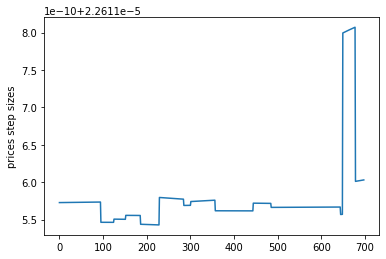

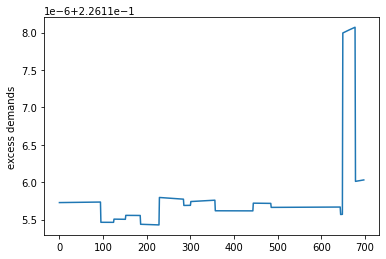

[array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724,

In [ ]:
num_goods = 2
num_buyers = 2
num_samples = 25
discount = 0.9

valuations = np.array([[21.26920423, 33.45640665],
 [45.06020981, 23.52635807]])

learn_rate_prices_linear = 1 

learn_rate_prices_leontief = 1

learn_rate_prices_cd =  1

num_iters_prices = 700 #30

value_coef = np.repeat(-8, num_buyers)
value_intercept = 10


budgets = np.array([5,5])


utility_type = "cd"

# negative big 
# positive small

# real_learn_rate = (np.sum(budgets) / 25) * learn_rate_prices_cd * (1 / (1+math.exp(np.mean(value_coef)/10)))
real_learn_rate = 0.0001
# real_learn_rate = (np.sum(budgets) / 8) * learn_rate_prices_cd * (1 / np.linalg.norm(value_coef).clip(10))
# real_learn_rate = 0.03
print(real_learn_rate)
prices_step_sizes, excess_demands_hist, value = min_max_value_deterministic_linear(budgets, valuations, value_coef, value_intercept, discount, 
                                                                                           real_learn_rate, 
                                                                                           num_iters_prices, utility_type)

plt.plot(prices_step_sizes[1:])
plt.ylabel("prices step sizes")
plt.show()

excess_demands_norms = [np.linalg.norm(excess_demands) for excess_demands in excess_demands_hist]
plt.plot(excess_demands_norms[1:])
plt.ylabel("excess demands")
plt.show()

print(excess_demands_hist)
print(excess_demands_hist[-1])

In [ ]:
X = cp.Variable(valuations.shape)
if utility_type == "linear":
  util = cp.sum(cp.multiply(valuations, X), axis=1)
elif utility_type == "leontief":
  util = cp.min(cp.multiply(1/valuations, X), axis=1)
elif utility_type == "cd":
  util = cp.sum(cp.multiply(valuations, cp.log(X)), axis=1) + 5

# prices = np.array([5.04939342, 4.76537932])
prices = np.array([5.05040018, 4.76630362])
budgets = np.array([9.508242, 9.890914])

obj = cp.Maximize(cp.sum(prices)  + budgets.T @ cp.log(util) + discount*((cp.sum(X, axis=1)).T @ value_coef + value_intercept))
constr = [X>=0, X @ prices <= budgets]
prob = cp.Problem(obj, constr)
# Form and solve problem.
prob = cp.Problem(obj, constr)
try:
    prob.solve(solver="ECOS")
except cp.SolverError:
    prob.solve(solver="MOSEK")
# print(prob.status)
# print(demands)
if (prob.status == cp.UNBOUNDED):
  print("unbounded")
elif (prob.status == cp.INFEASIBLE):
  print("infeasible")
demands = X.value

demands = np.array([[0.1,0.1], [0.1, 0.1]])
print(budgets @ demands)

[1.9399156 1.9399156]


In [ ]:
print(prices_step_sizes)

[2.2611572787604942e-05, 2.26115727945714e-05, 2.261157280143715e-05, 2.261157280806234e-05, 2.2611572814956063e-05, 2.2611572821800502e-05, 2.2611572828519205e-05, 2.2611572835367283e-05, 2.261157284218033e-05, 2.261157284940392e-05, 2.2611572856207506e-05, 2.2611572862922878e-05, 2.2611572869978056e-05, 2.2611572876744734e-05, 2.2611572883875017e-05, 2.2611572890935538e-05, 2.261157289810468e-05, 2.2611572905027324e-05, 2.26115729121208e-05, 2.2611572919165347e-05, 2.2611572925854698e-05, 2.261157293328507e-05, 2.2611572940321685e-05, 2.261157294758714e-05, 2.261157295490985e-05, 2.2611572962291094e-05, 2.261157296936916e-05, 2.2611572976460546e-05, 2.2611572984061217e-05, 2.2611572991200312e-05, 2.2611572998625443e-05, 2.261157300569791e-05, 2.261157301310567e-05, 2.2611573020437043e-05, 2.261157302778496e-05, 2.2611573035164385e-05, 2.2611573042733695e-05, 2.261157305006032e-05, 2.261157305748661e-05, 2.2611573065091177e-05, 2.2611573072672244e-05, 2.261157307978232e-05, 2.26115730

In [ ]:
print(excess_demands_hist)

[array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724, -0.20845874]), array([-0.08759724,

### Deterministic Value Iteration Linear

In [ ]:
# The main function for value iteration
def fitted_linear_val_iter_deterministic(valuations, value_coef, value_intercept, discount, learn_rate_prices, 
                                                                    num_iters_VI, num_iters_prices, 
                                                                    num_samples, utility_type):
    coef_hist = [value_coef]
    intercept_hist = [value_intercept]

    values_hist = []
    budgets_hist = []
    excess_demands_hist = []
    
    num_buyers = valuations.shape[0]
    num_goods = valuations.shape[1]

    for iter in range(num_iters_VI):
        print(f"----------Value Iteration {iter}------------")
        values = []
        budgets_samples = np.random.uniform(9, 10, (num_samples, num_buyers))
        budgets_hist.append(budgets_samples)
        
        for index, budgets in enumerate(budgets_samples): 
            print(f"_____Sample {index}_____")
            # value, prices, allocations, savings = min_max_linear_value_manual_project(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, num_iters_prices, num_iters_demands, utility_type)
            excess_demands_sum = 0
            learn_rate_prices_real = (np.sum(budgets) / 25) * learn_rate_prices_cd * (1 / (1+math.exp(np.mean(value_coef)/10)))
            value, excess_demands = min_max_value_deterministic_linear(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices_real, num_iters_prices, utility_type)
            values.append(value)
            excess_demands_sum += np.linalg.norm(excess_demands)
        
        values = np.array(values)
        values_hist.append(values)
        excess_demands_hist.append(excess_demands_sum / num_samples)
        

        reg = linear_model.LinearRegression()
        reg.fit(budgets_samples, values)
        value_coef = reg.coef_ # Update the parameters
        value_intercept = reg.intercept_ # Update the intercept
        
        coef_hist.append(value_coef)
        intercept_hist.append(value_intercept)
        values_hist.append(values)
        budgets_hist.append(budgets_samples)

        print("value coef:", value_coef)

        # coef_hist_filename = f"/content/drive/My Drive/exp_results/exp_results_{utility_type}_concave_fitted/coef_hist_{iter}_{utility_type}_fisher.npy"
        # intercept_hist_filename = f"/content/drive/My Drive/exp_results/exp_results_{utility_type}_concave_fitted/intercept_hist_{iter}_{utility_type}_fisher.npy"
        # values_hist_filename = f"/content/drive/My Drive/exp_results/exp_results_{utility_type}_concave_fitted/values_hist_{iter}_{utility_type}_fisher.npy"
        # budgets_hist_filename = f"/content/drive/My Drive/exp_results/exp_results_{utility_type}_concave_fitted/budgets_hist_{iter}_{utility_type}_fisher.npy"
        # with open(coef_hist_filename, 'wb') as f:
        #     np.save(f, coef_hist)

        # with open(intercept_hist_filename, 'wb') as f:
        #     np.save(f, intercept_hist)

        # with open(values_hist_filename, 'wb') as f:
        #     np.save(f, values_hist)


        # with open(budgets_hist_filename, 'wb') as f:
        #     np.save(f, budgets_hist)

    return (coef_hist, intercept_hist, values_hist, budgets_hist, excess_demands_hist)

## Experiments

### Deterministic Linear

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

num_goods = 2
num_buyers = 2
discount = 0.9



valuations = np.array([[21.26920423, 33.45640665],
 [45.06020981, 23.52635807]])

learn_rate_prices_linear = 1 
learn_rate_demands_linear = 0.01 

learn_rate_prices_leontief = 1
learn_rate_demands_leontief = 0.01

learn_rate_prices_cd = 1
learn_rate_demands_cd = 0.01

num_iters_VI = 30  #50
num_iters_prices = 600 #30
num_samples = 25 #25

value_coef = np.repeat(10, num_buyers)
value_intercept = 10


# real_learn_rate = (np.sum(budgets) / 2) * learn_rate_prices_leontief * (1 / (1+math.exp(np.mean(value_coef)/10)))
# real_learn_rate = (np.sum(budgets) / 2) * learn_rate_prices_leontief * (10 / np.linalg.norm(value_coef).clip(10))
# real_learn_rate = (np.sum(budgets) / 50) * learn_rate_prices_cd * (1 / (1+math.exp(np.mean(value_coef)/10)))


coef_hist_cd, intercept_hist_cd, values_hist_cd, budgets_hist_cd, excess_demands_hist = fitted_linear_val_iter_deterministic(valuations, 
                                                                    value_coef, value_intercept, discount, learn_rate_prices_cd, 
                                                                    num_iters_VI, num_iters_prices,
                                                                    num_samples, "cd")

print(excess_demands_hist)
utility_type = "cd"
coef_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_coef_hist.npy"
intercept_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_intercept_hist.npy"
values_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_values_hist.npy"
budgets_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_budgets_hist.npy"
with open(coef_hist_filename, 'wb') as f:
    np.save(f, coef_hist_cd)
with open(intercept_hist_filename, 'wb') as f:
    np.save(f, intercept_hist_cd)
with open(values_hist_filename, 'wb') as f:
    np.save(f, values_hist_cd)
with open(budgets_hist_filename, 'wb') as f:
    np.save(f, budgets_hist_cd)

# coef_hist_cd, intercept_hist_cd, values_hist_cd, budgets_hist_cd, model_hist_cd = fitted_concave_val_iter_deterministic(valuations, value_coefs, value_intercepts, discount, learn_rate_prices_cd, learn_rate_demands_cd, 
#                                                                     num_iters_VI, num_iters_prices, num_iters_demands, 
#                                                                     num_samples, "cd")

# utility_type = "cd"
# coef_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_coef_hist.npy"
# intercept_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_intercept_hist.npy"
# values_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_values_hist.npy"
# budgets_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_budgets_hist.npy"
# with open(coef_hist_filename, 'wb') as f:
#     np.save(f, coef_hist_cd)
# with open(intercept_hist_filename, 'wb') as f:
#     np.save(f, intercept_hist_cd)
# with open(values_hist_filename, 'wb') as f:
#     np.save(f, values_hist_cd)
# with open(budgets_hist_filename, 'wb') as f:
#     np.save(f, budgets_hist_cd)

Streaming output truncated to the last 5000 lines.
budgets: [9.40877383 9.29612777]
demands: [[0.40486399 0.64153983]
 [0.59496236 0.35861621]]
prices: [10.94995118  7.75562915]
value: -1417.285528357184
excess demands: [-0.00017366  0.00015605]
_____Sample 9_____

****Min-Max Price Iteration 50****

****Min-Max Price Iteration 100****

****Min-Max Price Iteration 150****

****Min-Max Price Iteration 200****

****Min-Max Price Iteration 250****

****Min-Max Price Iteration 300****

****Min-Max Price Iteration 350****

****Min-Max Price Iteration 400****

****Min-Max Price Iteration 450****

****Min-Max Price Iteration 500****

****Min-Max Price Iteration 550****
------------------------------------------------------------------
budgets: [9.49340696 9.65704368]
demands: [[0.39665201 0.6358346 ]
 [0.60327594 0.36422918]]
prices: [11.21861119  7.93213302]
value: -1420.9440954406152
excess demands: [-7.20431547e-05  6.37811802e-05]
_____Sample 10_____

****Min-Max Price Iteration 50****

*

In [ ]:
print(excess_demands_hist)

[3.900801131927009e-07, 4.427828468178781e-06, 1.7017300994434265e-05, 3.342984435840195e-05, 2.8448071408789237e-06, 3.4597973085283307e-06, 2.0697229020275046e-05, 8.662215588948865e-06, 3.4370975331553956e-05, 1.0682932015147813e-06, 3.628040023934856e-05, 1.9214599576503172e-06, 3.7005177032389314e-06, 9.11366941124157e-06, 3.377665348471305e-05, 2.5413591778866594e-05, 9.534111099026621e-06, 4.195601433594495e-05, 4.0570629196231684e-06, 1.5592754553520725e-06, 1.8625852455368227e-06, 4.137299607190363e-06, 3.576088977389187e-05, 2.389520865609535e-06, 4.993955090774268e-06, 7.206562332383587e-06, 3.141035824445388e-06, 4.51852658661527e-06, 3.4152278043012585e-05, 5.153267948904751e-06]


In [ ]:
print(coef_hist_cd)
print(intercept_hist_cd)

[array([10, 10]), array([-8.21033247, -8.21033204]), array([-8.13366881, -8.08131743]), array([-8.18930685, -8.19163884]), array([-8.10550975, -8.11281962]), array([-8.21148051, -8.21119433]), array([-8.14776094, -8.16300669]), array([-8.13798248, -8.15130961]), array([-8.16410664, -8.18964082]), array([-8.07478571, -8.0195296 ]), array([-8.20775432, -8.20891257]), array([-8.12625765, -8.08761121]), array([-8.21045164, -8.20473558]), array([-8.07827134, -8.07764442]), array([-8.21150495, -8.21126084]), array([-8.16653053, -8.11768126]), array([-8.10586052, -8.1177626 ]), array([-8.2113034 , -8.21145252]), array([-8.12874349, -8.03779764]), array([-8.21125418, -8.21096155]), array([-8.07645891, -8.06213256]), array([-8.18389954, -8.19313677]), array([-8.20332625, -8.19844063]), array([-8.12288746, -8.07063493]), array([-8.17271105, -8.18204864]), array([-8.13393757, -8.12410173]), array([-8.20396667, -8.20115528]), array([-8.04691022, -8.08300201]), array([-8.17482038, -8.185558  ]), ar

### Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


utility_type = "cd"
coef_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_coef_hist.npy"
intercept_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_intercept_hist.npy"
values_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_values_hist.npy"
budgets_hist_filename = f"/content/drive/My Drive/exp_results/deterministic/{utility_type}_budgets_hist.npy"

with open(coef_hist_filename, 'rb') as f:
    coef_hist_cd = np.load(f)
with open(intercept_hist_filename, 'rb') as f:
    intercept_hist_cd = np.load(f)
with open(values_hist_filename, 'rb') as f:
    values_hist_cd = np.load(f)
with open(budgets_hist_filename, 'rb') as f:
    budgets_hist_cd = np.load(f)

In [ ]:
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# the function that I'm going to plot
def z_func(x,y,value_coef, value_intercept):
 budgets = np.array([x,y]) 
 return budgets.T @ value_coef + value_intercept

value_coef = coef_hist_cd[1]
value_intercept = intercept_hist_cd[1]
x = arange(9,10,0.01)
y = arange(9,10,0.01)
X,Y = meshgrid(x, y) # grid of point
Z = z_func(X, Y, value_coef, value_intercept) # evaluation of the function on the grid

im = imshow(Z,cmap=cm.RdBu) # drawing the function
# adding the Contour lines with labels
cset = contour(Z,arange(-100,0, 1),linewidths=2,cmap=cm.Set2)
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
colorbar(im) # adding the colobar on the right
# latex fashion title
title('value function')
show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import cdLocator, FormatStrFormatter
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
fig, ax = plt.subplots()


# print(np.minimum(slopes_hist[0][0]*x+intercepts_hist[0][0], slopes_hist[0][1]*x+intercepts_hist[0][1]))
def animate(i):
  value_coef = coef_hist_cd[i]
  value_intercept = intercept_hist_cd[i]
  x = arange(9,10,0.01)
  y = arange(9,10,0.01)
  X,Y = meshgrid(x, y) # grid of point
  Z = z_func(X, Y, value_coef, value_intercept) # evaluation of the function on the grid

  im = imshow(Z,cmap=cm.RdBu) # drawing the function
  c = ax.pcolormesh(x, y, Z, cmap='RdBu')
  ax.set_title('pcolormesh')
  # set the limits of the plot to the limits of the data
  ax.axis([9,10,9,10])



ani = animation.FuncAnimation(fig, animate, frames=num_iters_VI, interval=100, repeat=False)

ani